<a href="https://colab.research.google.com/github/vineetjoshi253/Using-Deep-Reinforcement-Learning-For-Imbalanced-Data-Classification/blob/main/CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# utility library
import os
import time
import copy
import random
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

#Library for image Augumentation
from skimage import io
from PIL import Image
from skimage.transform import rotate,AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

#sklearn method to split the method
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
# from imblearn.metrics import geometric_mean_score

#Pytorch import
import torch,torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils import data as d
import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn  

# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
'''
Loading undersampled data
'''
rootPath = '/content/drive/MyDrive/Mtech Sem3/RL/RL Project'
# trainX = np.load(os.path.join(rootPath,'79_40percent_undersampled_train.npy'))
# trainY = np.load(os.path.join(rootPath,'79_40percent_undersampled_train_labels.npy'))
# testX = np.load(os.path.join(rootPath,'79_40percent_undersampled_validation.npy'))
# testY = np.load(os.path.join(rootPath,'79_40percent_undersampled_validation_labels.npy'))

trainX = np.load(os.path.join(rootPath,'79_25percent_train_data.npy'))
trainY = np.load(os.path.join(rootPath,'79_25percent_train_labels.npy'))
testX = np.load(os.path.join(rootPath,'79_25percent_validation_data.npy'))
testY = np.load(os.path.join(rootPath,'79_25percent_validation_labels.npy'))


print('Training Features : ',trainX.shape)
print('Training Labels : ',trainY.shape)
print('Test Features : ',testX.shape)
print('Validation Labels : ',testY.shape)

print("Train Label",np.unique(trainY, return_counts = True))
print("Test Label",np.unique(testY, return_counts = True))

Training Features :  (6692, 28, 28)
Training Labels :  (6692,)
Test Features :  (744, 28, 28)
Validation Labels :  (744,)
Train Label (array([0, 1]), array([5354, 1338]))
Test Label (array([0, 1]), array([595, 149]))


## Treat Imbalance problem

In [ ]:
#Seperating the different classes image
labelClass0 = np.where(trainY == 0)[0]  # Class zero is for 9
labelClass1 = np.where(trainY == 1)[0]  # Class one is for 7 
class0Img = trainX[labelClass0]
class1Img = trainX[labelClass1]

In [ ]:
# Now we will do augumentation oversampling of smaller class
xAugData = []
for i in tqdm(range(class1Img.shape[0])):
    image = class1Img[i]
    xAugData.append(image)
    xAugData.append(rotate(image, angle=random.choice([-10,-5,0,5,10]), mode = 'wrap'))
    xAugData.append(random_noise(image,var=0.002))
    xAugData.append(gaussian(image,sigma=1,multichannel=False))
    transform = AffineTransform(translation=(2,3))
    xAugData.append(warp(image,transform,mode='wrap'))

In [ ]:
numberOfImagesToIncrease = class0Img.shape[0]
xAugData = np.array(xAugData)
print(xAugData.shape)
index = np.random.choice([i for i in range(len(xAugData))],numberOfImagesToIncrease)
xAugData = xAugData[index]
yAugData = np.ones(numberOfImagesToIncrease)
print(xAugData.shape,yAugData,yAugData.shape)

(6690, 28, 28)
(5354, 28, 28) [1. 1. 1. ... 1. 1. 1.] (5354,)


## Spliting the training into validation dataset

In [ ]:
#For Weighted technique
# ftrainX = trainX
# fTrainY = trainY
#For Oversampling technique
#Combine the two classes Data
ftrainX = np.concatenate((class0Img, xAugData), axis=0)
fTrainY = np.concatenate((np.zeros(numberOfImagesToIncrease),yAugData),axis = 0)
fTestX =  testX
fTestY =  testY 

In [ ]:
#Split the data into train and validation
xTrain,xVal , yTrain ,yVal = train_test_split(ftrainX,fTrainY, test_size=0.25, stratify = fTrainY,random_state = manualSeed )
#priting all shapes
print('Complete Data size:\n',ftrainX.shape,"\n", np.unique(fTrainY,return_counts=True))
print('Training Data size:\n',xTrain.shape,"\n", np.unique(yTrain,return_counts=True))
print('Validation Data:\n',xVal.shape,'\n', np.unique(yVal,return_counts=True))
print('Test Data:\n',fTestX.shape,'\n',np.unique(fTestY,return_counts=True))

Complete Data size:
 (10708, 28, 28) 
 (array([0., 1.]), array([5354, 5354]))
Training Data size:
 (8031, 28, 28) 
 (array([0., 1.]), array([4015, 4016]))
Validation Data:
 (2677, 28, 28) 
 (array([0., 1.]), array([1339, 1338]))
Test Data:
 (744, 28, 28) 
 (array([0, 1]), array([595, 149]))


## Define Coustom DataSet

In [ ]:
# 0 for  healthy and 1 for cancer
class MNIST_79(Dataset):
  def __init__(self,img,label,transform=None):
    self.img = img
    self.img = np.expand_dims(self.img, axis=1)
    self.img = self.img/255
    self.label = label
    self.transform = transform
  
  def __len__(self):
      return len(self.label)

  def __getitem__(self, idx):
      img = self.img[idx]
      if self.transform:
          img = self.transform(img)
      
      label = self.label[idx]
      return img,label

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])
transform = None
#Training DataSet
datasetTraining = MNIST_79(xTrain,yTrain,transform=transform)
#Validation DataSet
datasetValidation = MNIST_79(xVal,yVal,transform=transform)
#Test Dataset
datasetTest = MNIST_79(fTestX,fTestY,transform=transform)

params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 2}

trainLoader = torch.utils.data.DataLoader(datasetTraining, **params)
valLoader = torch.utils.data.DataLoader(datasetValidation, **params)
testLoader = torch.utils.data.DataLoader(datasetTest, **params)


## Defining Network

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2,stride=2)
            )
        self.model = nn.Sequential(
            nn.Linear(in_features = 512 , out_features = 8),
            nn.ReLU(),
            nn.Linear(in_features = 8 , out_features = 2),
        )
        
    def forward(self, x):
        output = self.CNN(x)
        output = output.view(output.shape[0],-1)
        output = self.model(output)
        # print(output.shape)
        return output

In [ ]:
# model  = SimpleCNN()
# print(sum(p.numel() for p in model.parameters() if p.requires_grad))
# xBatch,yBatch = next(iter(trainLoader))
# print(xBatch.shape,yBatch.shape)
# op = model(xBatch.float())
# op.shape

4954
torch.Size([16, 1, 28, 28]) torch.Size([16])


torch.Size([16, 2])

In [ ]:
# model  = SimpleCNN()
# model.eval()
# for x,Lbl in trainLoader:
#   op = model(x.float())
#   print(op)

In [ ]:
def trainModelCNN(lr,epochs,model,trainLoader,ValLoader,savePath,saveModel = False,weightDecay = 0.01):
  criterion = nn.CrossEntropyLoss()  #torch.tensor([1,1.5]).to(device)
  optimizer = optim.AdamW(model.parameters(), lr=lr,weight_decay =  weightDecay)
  # optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay =  weightDecay,momentum = 0.9)
  epochs = epochs
  steps = 0
  minValLoss = 1000
  for e in tqdm(range(epochs)):
      runningLoss = 0
      for trainX, labels in trainLoader:
          optimizer.zero_grad()
          forward = model(trainX.float().to(device))
          loss = criterion(forward, labels.long().to(device))
          loss.backward()
          optimizer.step()
          runningLoss += loss.item()
          
      else:
          valLoss = 0
          valPredict= []
          valLabel =  []
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              model.eval()
              for valX, labels in ValLoader:
                  forward = model(valX.float().to(device))
                  valLoss += criterion(forward, labels.long().to(device))
                  
                  _, predict = torch.max(forward, 1)
                  valLabel += list(torch.squeeze(labels.int()).numpy())
                  valPredict += list(torch.squeeze(predict.int().cpu()).numpy())
              
              trainLabel = []
              predictLabel = []
              for trainX, labels in trainLoader:
                  forward = model(trainX.float().to(device))
                  
                  _, predict = torch.max(forward, 1)
                  trainLabel += list(torch.squeeze(labels.int()).numpy())
                  predictLabel += list(torch.squeeze(predict.int().cpu()).numpy())
                  
          model.train()

          trainLosses.append(runningLoss/len(trainLoader))
          valLosses.append(valLoss/len(ValLoader))
           
          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(trainLosses[-1]),
                "Val Loss: {:.3f}.. ".format(valLosses[-1]),
                "Train Accuracy: {:.3f}..".format(accuracy_score(trainLabel,predictLabel)),
                "Val Accuracy: {:.3f}..".format(accuracy_score(valLabel,valPredict)),
                "Train F1 Score: {:.3f}..".format(f1_score(trainLabel, predictLabel)),
                "Val F1 Score: {:.3f}".format(f1_score(valLabel,valPredict))
                )
          if(saveModel and valLoss < minValLoss):
            #saveModel
            minValLoss = valLoss
            torch.save(model.state_dict(), savePath)
            print("Model Saved")

In [ ]:
# def init_weights(m):
#     if type(m) == nn.Conv1d:
#         torch.nn.init.kaiming_uniform_(m.weight)
#         m.bias.data.fill_(0.01)

In [ ]:
lr = 0.001
epochs = 150
savePath = '/content/drive/MyDrive/Mtech Sem3/RL/RL Project/Models/MNIST 0.3/CNN_Oversampling_79_25.torch'
trainLosses, valLosses = [], []
modelCNN = SimpleCNN().to(device) 
# modelCNN.apply(init_weights)

In [ ]:
trainModelCNN(lr,epochs,modelCNN,trainLoader,valLoader,savePath,True,0) 

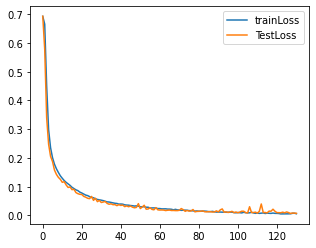

In [ ]:
plt.figure( figsize= (5,4))
plt.plot(trainLosses,label = "trainLoss")
plt.plot(valLosses,label ="TestLoss")
plt.legend()
plt.show()

In [ ]:
savePath = '/content/drive/MyDrive/Mtech Sem3/RL/RL Project/Models/MNIST 0.4/CNN_Weighted_100Epoch_79_40Data.torch'
torch.save(modelCNN.state_dict(), savePath)

In [ ]:
savePath = '/content/drive/MyDrive/Mtech Sem3/RL/RL Project/Models/MNIST 0.3/CNN_Oversampling_79_25.torch'
modelCNN.load_state_dict(torch.load(savePath))

<All keys matched successfully>

In [ ]:
# modelCNN = modelCNN.to(device)
modelCNN.eval()
testPredictLabel = []
testLabel = []
for img, label in testLoader:
  if (img.shape[0] == 1):
    continue;
  forward = modelCNN(img.float().to(device))
  _, predict = torch.max(forward, 1)
  testPredictLabel += list(torch.squeeze(predict.int().cpu()).numpy())
  testLabel += list(torch.squeeze(label.int()).numpy())

print(np.unique(testPredictLabel,return_counts= True))
print(np.unique(testLabel,return_counts= True))
print("Test Accuracy: {:.3f}..".format(accuracy_score(testLabel,testPredictLabel)))
print("Test F1 Score: {:.3f}..".format(f1_score(testLabel,testPredictLabel)))
print("Classification report: \n",classification_report(testLabel,testPredictLabel))

(array([0, 1], dtype=int32), array([589, 155]))
(array([0, 1], dtype=int32), array([595, 149]))
Test Accuracy: 0.989..
Test F1 Score: 0.974..
Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       595
           1       0.95      0.99      0.97       149

    accuracy                           0.99       744
   macro avg       0.98      0.99      0.98       744
weighted avg       0.99      0.99      0.99       744

